In [ ]:
!nvidia-smi

Mon Jul 22 14:37:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
try:
  import mat73
except:
  !pip install mat73
  import mat73

In [ ]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
import time
import pandas as pd
import scipy
import scipy.io

from numpy import linalg as LA
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.extmath import randomized_svd
from matplotlib.animation import FuncAnimation, writers

from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from scipy.io import savemat

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

from keras.callbacks import Callback

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv2D, ConvLSTM2D, Conv2DTranspose, SeparableConv2D, Flatten, Reshape, LeakyReLU, ReLU, Input
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, UpSampling2D, TimeDistributed, LayerNormalization
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dropout, BatchNormalization

In [ ]:
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [ ]:
print(tf.__version__)
tf.test.gpu_device_name()

2.15.0


'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11537311472200435484
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14871815175839040404
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
seed = 98374598
tf.random.set_seed(seed)
np.random.seed(seed)

# 1. Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set working directory
import os
os.chdir("//content/drive/My Drive/abadiaheredia_etal_2024/")

In [ ]:
data_dict = mat73.loadmat('DATA/dataset_experimental.mat')

Ten_orig_1 = data_dict['Tensor'][0:1,:,:,:]

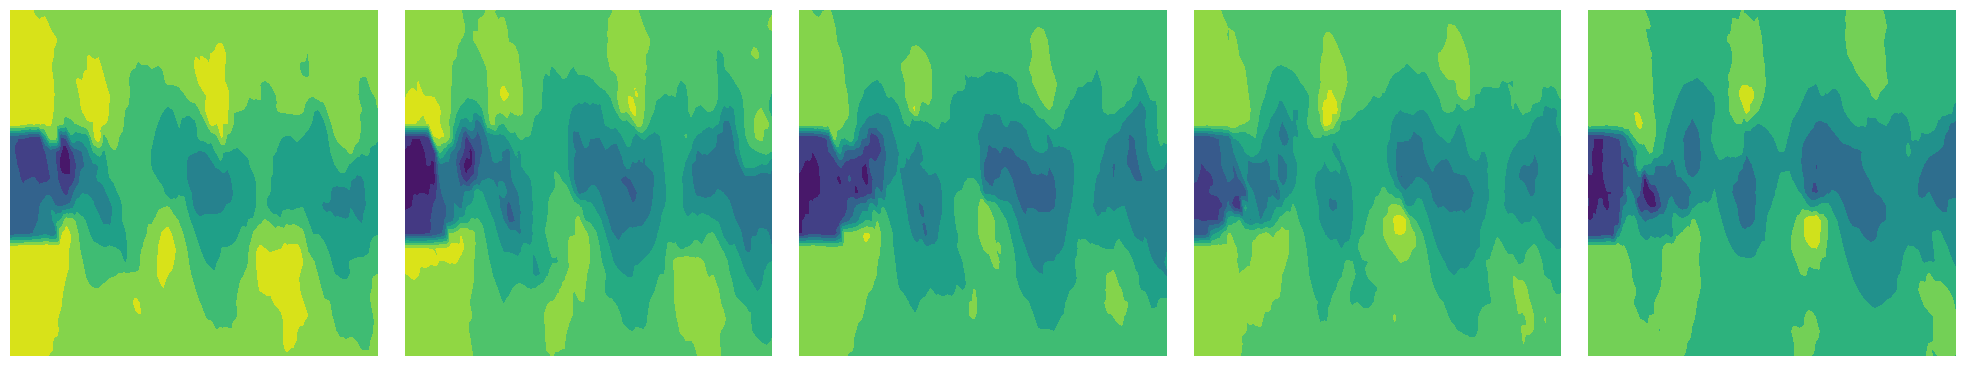

In [ ]:
fig, axes = plt.subplots(1, 5, figsize = (20,4))

axes[0].contourf(Ten_orig_1[0,:,:,0])
axes[0].axis('off')
axes[1].contourf(Ten_orig_1[0,:,:,1])
axes[1].axis('off')
axes[2].contourf(Ten_orig_1[0,:,:,2])
axes[2].axis('off')
axes[3].contourf(Ten_orig_1[0,:,:,3])
axes[3].axis('off')
axes[4].contourf(Ten_orig_1[0,:,:,4])
axes[4].axis('off')

fig.tight_layout()

# SVD

In [ ]:
train_set_1 = np.copy(Ten_orig_1[:1,...,:int(0.7*Ten_orig_1.shape[-1])])
dev_set_1 = np.copy(Ten_orig_1[:1,...,:int(0.75*Ten_orig_1.shape[-1])])

train_mean = np.mean(np.copy(Ten_orig_1[:1,...,:int(0.7*Ten_orig_1.shape[-1])]), axis = -1)
dev_mean = np.mean(np.copy(Ten_orig_1[:1,...,:int(0.75*Ten_orig_1.shape[-1])]), axis = -1)

train_set_1 = train_set_1 - train_mean[..., None]
dev_set_1 = dev_set_1 - dev_mean[..., None]

In [ ]:
Utr, Str, VTtr = LA.svd(
    np.reshape(
        np.copy(train_set_1),
        [np.product(train_set_1.shape[:-1]), train_set_1.shape[-1]],
        order = 'F'),
    full_matrices = False)

Udev, Sdev, VTdev = LA.svd(
    np.reshape(
        np.copy(dev_set_1),
        [np.product(dev_set_1.shape[:-1]), dev_set_1.shape[-1]],
        order = 'F'),
    full_matrices = False)

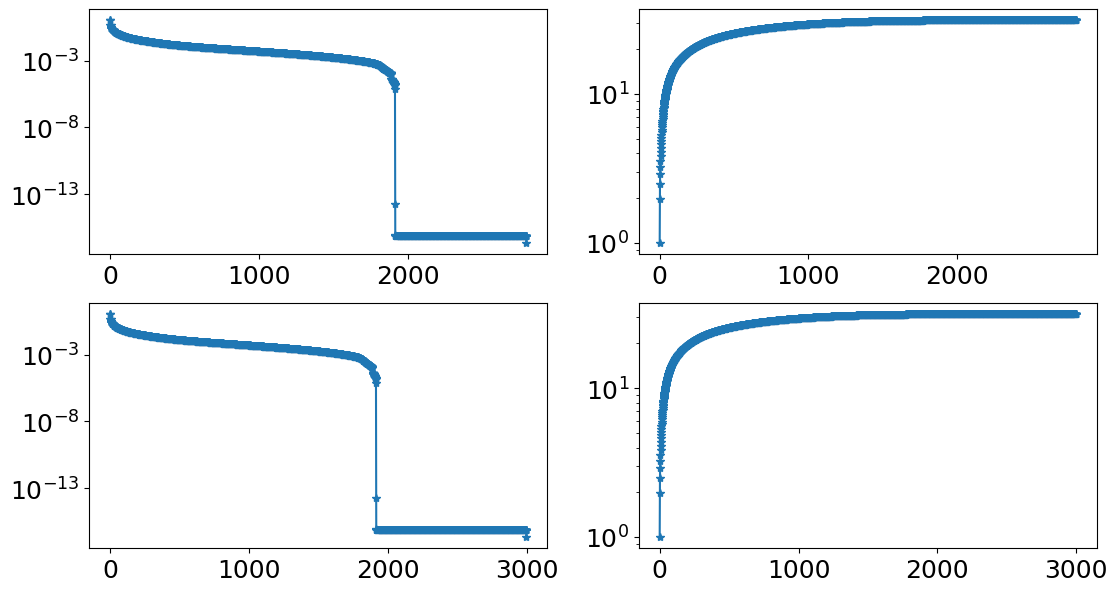

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (13, 7))
axs[0,0].plot(Str/np.max(Str), '-*')
axs[0,0].set_yscale('log')

axs[0,1].plot(np.cumsum(Str/np.max(Str)), '-*')
axs[0,1].set_yscale('log')

axs[1,0].plot(Sdev/np.max(Sdev), '-*')
axs[1,0].set_yscale('log')

axs[1,1].plot(np.cumsum(Sdev/np.max(Sdev)), '-*')
axs[1,1].set_yscale('log')

In [ ]:
_ = np.cumsum(Str/np.max(Str))
print(_[100]/_[-1])
_ = Str/np.max(Str)
print(_[100]/_[0])
del _

_ = np.cumsum(Sdev/np.max(Sdev))
print(_[100]/_[-1])
_ = Sdev/np.max(Sdev)
print(_[100]/_[0])
del _

0.48521921222044456
0.06128851512403391
0.48355853319675995
0.06180801956418328


In [ ]:
num_modes = 100
train_set_recon = np.dot(Utr[:,:num_modes], np.dot(np.diag(Str[:num_modes]), VTtr[:num_modes,:]))
train_set_recon = np.reshape(train_set_recon, [1,111,301,train_set_1.shape[-1]], order = 'F')
train_set_recon = train_set_recon + train_mean[..., None]

dev_set_recon = np.dot(Udev[:,:num_modes], np.dot(np.diag(Sdev[:num_modes]), VTdev[:num_modes,:]))
dev_set_recon = np.reshape(dev_set_recon, [1,111,301,dev_set_1.shape[-1]], order = 'F')
dev_set_recon = dev_set_recon + dev_mean[..., None]
dev_set_recon = dev_set_recon[..., train_set_recon.shape[-1]:]

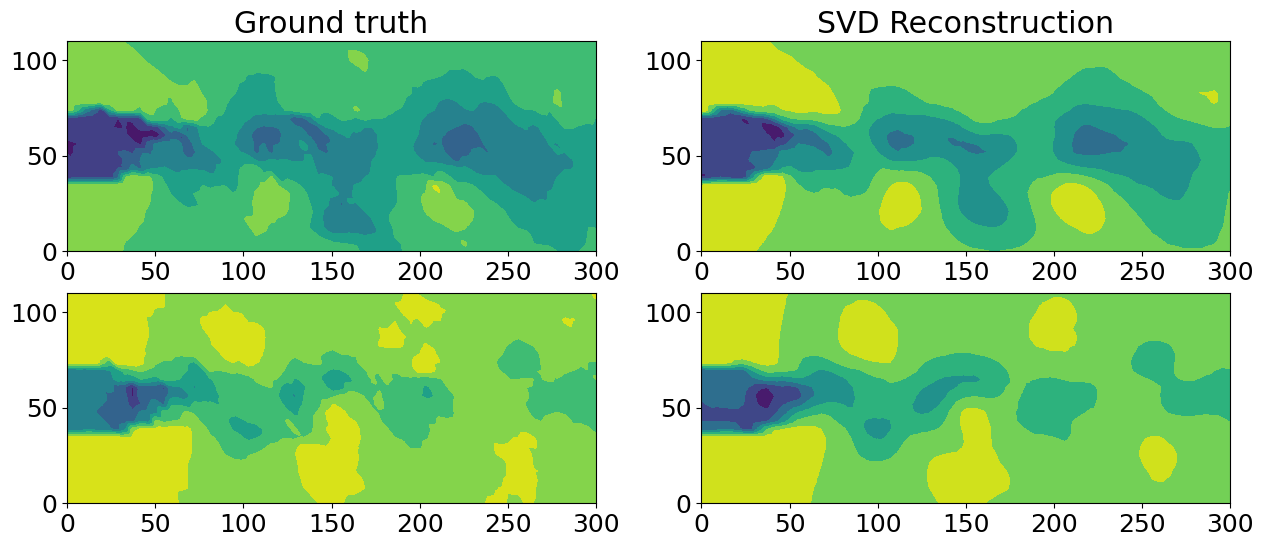

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (15,6))
axs[0,0].contourf(Ten_orig_1[0,:,:,100])
axs[0,0].set_title('Ground truth')
axs[0,1].contourf(train_set_recon[0,:,:,100])
axs[0,1].set_title('SVD Reconstruction')

axs[1,0].contourf(Ten_orig_1[0,:,:,train_set_recon.shape[-1] + 10])
axs[1,1].contourf(dev_set_recon[0,:,:,10])

In [ ]:
# Scailing between 0 and 1
ten_min = np.amin(train_set_recon)
ten_range = np.ptp(train_set_recon)

train_set = (train_set_recon - ten_min) / ten_range
dev_set = (dev_set_recon - ten_min) / ten_range

# Channels last, time first
train_set = np.transpose(train_set, (3, 1, 2, 0))
dev_set = np.transpose(dev_set, (3, 1, 2, 0))

print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")

Train set shape: (2800, 111, 301, 1)
Dev set shape: (200, 111, 301, 1)


In [ ]:
print(np.amin(train_set))
print(np.amax(train_set))
print(np.mean(train_set))
print(np.std(train_set))

0.0
1.0
0.6737263115227213
0.08766775626404696


# 2. Data Split

In [ ]:
train_set_1 = np.copy(train_set_recon[...,:int(0.7*train_set_recon.shape[-1])])
dev_set_1 = np.copy(train_set_recon[...,int(0.65*train_set_recon.shape[-1]):int(0.7*train_set_recon.shape[-1])])

# mean_flow = np.mean(train_set_1, axis = -1)[..., None]
# train_set_1 -= mean_flow
# dev_set_1 -= mean_flow

# Scailing between 0 and 1
ten_min_1 = np.amin(train_set_1)
ten_range_1 = np.ptp(train_set_1)

train_set_1 = (train_set_1 - ten_min_1) / ten_range_1
dev_set_1 = (dev_set_1 - ten_min_1) / ten_range_1

# Channels last, time first
train_set = np.transpose(train_set_1, (3, 1, 2, 0))
dev_set = np.transpose(dev_set_1, (3, 1, 2, 0))

print(f"Train set shape: {train_set.shape}")
print(f"Dev set shape: {dev_set.shape}")

Train set shape: (1959, 111, 301, 1)
Dev set shape: (139, 111, 301, 1)


In [ ]:
print("Training statistics")
print(np.mean(train_set))
print(np.std(train_set))
print(np.amin(train_set))
print(np.amax(train_set))

Training statistics
0.6660112334300686
0.09010522008172037
0.0
1.0


# 3. Data Windowing

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, samplingRate, batch_size, case="training",
            train_df=train_set_1, val_df=dev_set_1, test_df=train_set_1):

        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sampling_rate = samplingRate

        # Store case
        self.case = case

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}'])

def split_window(self, features):

    inputs = features[:, self.input_slice, ...]
    labels = features[:, self.labels_slice, ...]

    inputs.set_shape([None, self.input_width, None, None, None])
    labels.set_shape([None, self.label_width, None, None, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    if self.case == "training":
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            sampling_rate=self.sampling_rate,
            shuffle=True,
            batch_size=self.batch_size)

    else:
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=self.total_window_size,
            shuffle=False,
            batch_size=self.batch_size)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    # Get and cache an example batch of 'inputs, labels' for plotting.
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
inputWidth = 5 # 10
labelWidth = 1
shift = 1

batchSize = 8 #12 #32 #16 #8

w1 = WindowGenerator(input_width = inputWidth, label_width = labelWidth,
                     shift = shift, samplingRate = 1, batch_size = batchSize,
                     train_df = train_set,
                     val_df = dev_set,
                     test_df = train_set)

In [ ]:
print(f"Number of training batches: {len(w1.train)}")

for example_inputs, example_labels in w1.train.take(1):
  in_shape = (example_inputs.shape[1],example_inputs.shape[2],example_inputs.shape[3],example_inputs.shape[4])
  print(f'\nInputs shape (batch size, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch size, time, features): {example_labels.shape}')

Number of training batches: 245

Inputs shape (batch size, time, features): (8, 5, 111, 301, 1)
Labels shape (batch size, time, features): (8, 1, 111, 301, 1)


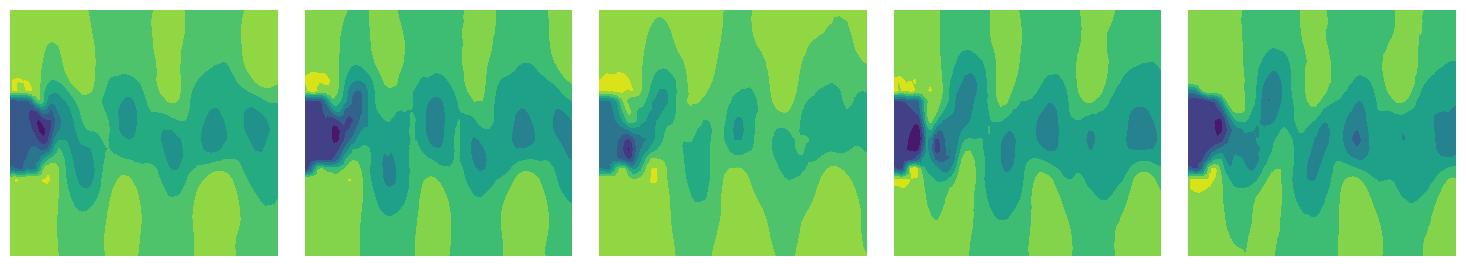

In [ ]:
plt.close('all')
fig, axes = plt.subplots(1, 5, figsize = (15,3))
axes[0].contourf(example_inputs[0,0,:,:,0])
axes[0].axis(False)
axes[1].contourf(example_inputs[0,1,:,:,0])
axes[1].axis(False)
axes[2].contourf(example_inputs[0,2,:,:,0])
axes[2].axis(False)
axes[3].contourf(example_inputs[0,3,:,:,0])
axes[3].axis(False)
axes[4].contourf(example_inputs[0,4,:,:,0])
axes[4].axis(False)

fig.tight_layout()

# 4. Autoencoder

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def identity_block(in_shape, filters=12, name=None):
  block_in = Input(shape=in_shape)
  x_1 = block_in

  x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(block_in)
  x = LayerNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(x)
  x = LayerNormalization()(x)
  x = Add()([x,x_1])
  block_out = ReLU()(x)

  return Model(inputs=block_in, outputs=block_out, name=name)

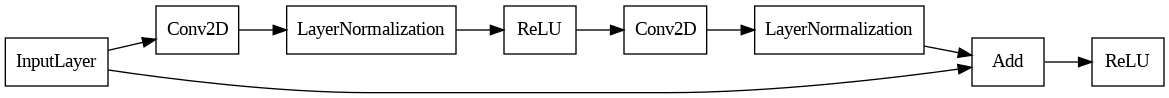

In [ ]:
model = identity_block(in_shape, in_shape[-1])
#model.summary()
tf.keras.utils.plot_model(model, show_layer_names=False, rankdir='LR')

In [ ]:
def conv_block(in_shape, filters=12, name=None):
  block_in = Input(shape=in_shape)
  x_1 = block_in

  x = Conv2D(filters=filters, kernel_size=3, strides=2, padding='same',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(block_in)
  x = LayerNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(x)
  x = LayerNormalization()(x)
  x_1 = Conv2D(filters=filters, kernel_size=1, strides=2, padding='valid',
             data_format='channels_last', use_bias = False, activation = None,
             kernel_initializer = 'he_normal')(x_1)
  x = Add()([x,x_1])
  block_out = ReLU()(x)

  return Model(inputs=block_in, outputs=block_out, name=name)

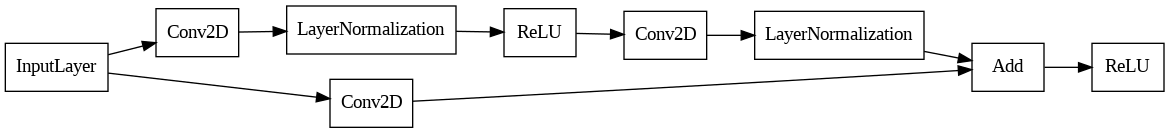

In [ ]:
model = conv_block(in_shape)
#model.summary()
tf.keras.utils.plot_model(model, show_layer_names=False, rankdir='LR')

In [ ]:

res_in = Input(shape=in_shape)

x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,2), padding='valid',
            activation=None, data_format='channels_last',
            kernel_initializer='he_normal')(res_in)
x = LayerNormalization()(x)
x = ReLU()(x)
x = Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='valid',
            activation=None, data_format='channels_last',
            kernel_initializer='he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

for i in range(3):
  name = 'identity_block_' + str(i)
  x = identity_block(x.shape[1:], filters=16, name=name)(x)

x = conv_block(x.shape[1:], filters=32, name='conv_block_1')(x)

for i in range(5):
  name = 'identity_block_' + str(i+3)
  x = identity_block(x.shape[1:], filters=32, name=name)(x)

x = conv_block(x.shape[1:], filters=64, name='conv_block_2')(x)

for i in range(3):
  name = 'identity_block_' + str(i+5+3)
  x = identity_block(x.shape[1:], filters=64, name=name)(x)

res_out = x

res_encoder = Model(inputs=res_in, outputs=res_out, name='res_encoder')

In [ ]:
res_in = Input(shape=in_shape)

x = Conv2D(filters=8, kernel_size=(7,7), strides=(1,2), padding='valid',
            activation=None, data_format='channels_last',
            kernel_initializer='he_normal')(res_in)
x = LayerNormalization()(x)
x = ReLU()(x)
x = Conv2D(filters=16, kernel_size=(5,5), strides=(1,2), padding='valid',
            activation=None, data_format='channels_last',
            kernel_initializer='he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

for i in range(3):
  name = 'identity_block_' + str(i)
  x = identity_block(x.shape[1:], filters=16, name=name)(x)

x = conv_block(x.shape[1:], filters=32, name='conv_block_1')(x)

for i in range(5):
  name = 'identity_block_' + str(i+3)
  x = identity_block(x.shape[1:], filters=32, name=name)(x)

x = conv_block(x.shape[1:], filters=64, name='conv_block_2')(x)

for i in range(3):
  name = 'identity_block_' + str(i+5+3)
  x = identity_block(x.shape[1:], filters=64, name=name)(x)

res_out = x

res_encoder_1 = Model(inputs=res_in, outputs=res_out, name='res_encoder')

In [ ]:
res_encoder_1.summary()

Model: "res_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 5, 111, 301, 1)   0         
                             ]                                   
                                                                 
 conv2d_35 (Conv2D)          (None, 5, 105, 148, 8)    400       
                                                                 
 layer_normalization_32 (La  (None, 5, 105, 148, 8)    16        
 yerNormalization)                                               
                                                                 
 re_lu_32 (ReLU)             (None, 5, 105, 148, 8)    0         
                                                                 
 conv2d_36 (Conv2D)          (None, 5, 101, 72, 16)    3216      
                                                                 
 layer_normalization_33 (La  (None, 5, 101, 72, 16)    

In [ ]:
dec_in = Input(shape=(14,19,128))

x = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='valid',
                    data_format='channels_last', activation = None,
                    use_bias = False, kernel_initializer = 'he_normal')(dec_in)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2),
                    padding='valid', data_format='channels_last',
                    activation = None, use_bias = False,
                    kernel_initializer = 'he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2D(filters=16, kernel_size=(5,5), strides=(1,1),
                    padding='valid', data_format='channels_last',
                    activation = None, use_bias = False,
                    kernel_initializer = 'he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(filters=8, kernel_size=(3,3), strides=(2,2),
                    padding='valid', data_format='channels_last',
                    activation = None, use_bias = False,
                    kernel_initializer = 'he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(filters=4, kernel_size=(1,1), strides=(1,2),
                    padding='valid', data_format='channels_last',
                    activation = None, use_bias = False,
                    kernel_initializer = 'he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2D(filters=1, kernel_size=(1,2), activation = None, use_bias = False,
                    kernel_initializer = 'glorot_uniform')(x)

x = Reshape((1,x.shape[1],x.shape[2],x.shape[3]))(x)

dec_out = x

res_decoder = Model(inputs=dec_in, outputs=dec_out, name='res_decoder')

In [ ]:
dec_in = Input(shape=(26,18,128))

x = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='valid',
                    data_format='channels_last', activation = None,
                    use_bias = False, kernel_initializer = 'he_normal')(dec_in)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2),
                    padding='valid', data_format='channels_last',
                    activation = None, use_bias = False,
                    kernel_initializer = 'he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(filters=8, kernel_size=(3,2), strides=(1,2),
                    padding='valid', data_format='channels_last',
                    activation = None, use_bias = False,
                    kernel_initializer = 'he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(filters=4, kernel_size=(3,3), strides=(1,2),
                    padding='valid', data_format='channels_last',
                    activation = None, use_bias = False,
                    kernel_initializer = 'he_normal')(x)
x = LayerNormalization()(x)
x = ReLU()(x)

x = Conv2D(filters = 1, kernel_size=(1,1), activation = None, use_bias = False,
                    kernel_initializer = 'glorot_uniform')(x)

x = Reshape((1,x.shape[1],x.shape[2],x.shape[3]))(x)

dec_out = x

res_decoder_1 = Model(inputs=dec_in, outputs=dec_out, name='res_decoder')

In [ ]:
res_decoder_1.summary()

Model: "res_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 26, 18, 128)]     0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 53, 37, 64)        73728     
 Transpose)                                                      
                                                                 
 layer_normalization_65 (La  (None, 53, 37, 64)        128       
 yerNormalization)                                               
                                                                 
 re_lu_65 (ReLU)             (None, 53, 37, 64)        0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 107, 75, 32)       18432     
 Transpose)                                                      
                                                       

In [ ]:
# hidden_in = Input(shape=(inputWidth, 14, 19, 64))
# hidden_in = Input(shape=(inputWidth, 13, 18, 64))
hidden_in = Input(shape=(inputWidth, 26, 18, 64))

x = ConvLSTM2D(128, (3, 3), padding="same", return_sequences=False,
                 data_format='channels_last', dropout=0.0, use_bias = False,
                 recurrent_dropout=0.0)(hidden_in)
x = LayerNormalization()(x)

hidden_out = x

hidden = Model(inputs=hidden_in, outputs=hidden_out, name='hidden')

In [ ]:
hidden.summary()

Model: "hidden"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 5, 26, 18, 64)]   0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 26, 18, 128)       884736    
                                                                 
 layer_normalization_69 (La  (None, 26, 18, 128)       256       
 yerNormalization)                                               
                                                                 
Total params: 884992 (3.38 MB)
Trainable params: 884992 (3.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
tf.keras.backend.clear_session()

input_DCA = Input(shape=in_shape)

x_enc = res_encoder_1(input_DCA)

x_hidden = hidden(x_enc)

out_DCA = res_decoder_1(x_hidden)

model_autoencoder = Model(inputs=input_DCA, outputs=out_DCA, name = 'residual_autoencoder')

In [ ]:
model_autoencoder.summary()

Model: "residual_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 111, 301, 1)   0         
                             ]                                   
                                                                 
 res_encoder (Functional)    (None, 5, 26, 18, 64)     404496    
                                                                 
 hidden (Functional)         (None, 26, 18, 128)       884992    
                                                                 
 res_decoder (Functional)    (None, 1, 111, 301, 1)    94204     
                                                                 
Total params: 1383692 (5.28 MB)
Trainable params: 1383692 (5.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5. Training

In [ ]:
filepath = "./CilindVKI_Results/ResidualAE_HODMD/autoencoder_bothVel_bestCheckpoint_weights.h5"

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor           = 'loss',
    save_best_only    = True,
    save_weights_only = True,
    mode              = 'min',
    save_freq         = 'epoch'
)]

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005) # 0.0005

t0 = time.time()

model_autoencoder.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
history = model_autoencoder.fit(w1.train, epochs = 80, callbacks = callbacks, validation_data = w1.val)

t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Epoch 1/80
350/350 [==============================] - 195s 470ms/step - loss: 2.8541e-04 - mae: 0.0110 - val_loss: 2.6329e-04 - val_mae: 0.0104
Epoch 2/80
350/350 [==============================] - 163s 466ms/step - loss: 2.4955e-04 - mae: 0.0103 - val_loss: 2.7096e-04 - val_mae: 0.0107
Epoch 3/80
350/350 [==============================] - 162s 464ms/step - loss: 2.5453e-04 - mae: 0.0105 - val_loss: 2.7890e-04 - val_mae: 0.0109
Epoch 4/80
350/350 [==============================] - 162s 464ms/step - loss: 2.5684e-04 - mae: 0.0106 - val_loss: 2.7652e-04 - val_mae: 0.0108
Epoch 5/80
350/350 [==============================] - 163s 464ms/step - loss: 2.5532e-04 - mae: 0.0105 - val_loss: 2.7433e-04 - val_mae: 0.0107
Epoch 6/80
350/350 [==============================] - 163s 464ms/step - loss: 2.5302e-04 - mae: 0.0105 - val_loss: 2.7239e-04 - val_mae: 0.0109
Epoch 7/80
350/350 [==============================] - 163s 464ms/step - loss: 2.5419e-04 - mae: 0.0105 - val_loss: 2.6614e-04 - val_mae:

In [ ]:
plt.close('all')

fig_loss = plt.figure(figsize=(12,6))
plt.subplot(2, 1, 1)
plt.plot(history.history["loss"], label='Training')
plt.plot(history.history["val_loss"], '--', label='Validation')
plt.legend()
plt.grid(True, which='both')

ax = plt.subplot(2, 1, 2)
ax.set_ylim(0, 0.005)
plt.plot(history.history["loss"], label='Training')
plt.plot(history.history["val_loss"], '--', label='Validation')
plt.legend()
plt.grid(True, which='both')

# Load weigths (IF the model was previously trained)

In [ ]:
!ls CilindVKI_Results/ResidualAE_HODMD

autoencoder_bestCheckpoint_weights_orig.h5
autoencoder_bothVel_bestCheckpoint_weights.h5
autoencoder_bothVel_bestCheckpoint_weights_orig_1.h5
autoencoder_bothVel_bestCheckpoint_weights_orig.h5
autoencoder_singleVel_bestCheckpoint_weights_FINAL.h5
model_autoencoder_weights.h5
model_encoder_weights.h5


In [ ]:
"""
vae.save_weights("./Models_weights/weights_residual_ae_experimental.h5")
"""

# vae.load_weights("./Models_weights/weights_residual_ae_experimental.h5")

# Evaluate Model

In [ ]:
def evaluate_model_test_iter(ten_orig_1, time_pred = 10, start_pnt = 10):

  ten_orig = np.copy(ten_orig_1)

  predictions = np.empty((ten_orig.shape[0], ten_orig.shape[1],
                          ten_orig.shape[2], time_pred))

  snap = np.copy(ten_orig[0:1, ..., start_pnt-5:start_pnt])
  snap = (snap - ten_min_1) / ten_range_1
  snap = np.transpose(snap, [3,1,2,0])
  snap = snap[None, ...]

  for i in range(time_pred):

    pred = model_autoencoder.predict(snap, verbose = 0)

    pred_1 = np.copy(pred[0,0,:,:,:]) * ten_range_1 + ten_min_1
    pred_1 = np.transpose(pred_1, [2,0,1])

    predictions[...,i] = pred_1

    snap = np.concatenate([snap[:,1:,:,:,:], pred], axis = 1)

  del ten_orig, snap, pred, pred_1

  return predictions

In [ ]:
t0 = time.time()

start_pnt = train_set.shape[0]
predictions = evaluate_model_test_iter(train_set_recon, 200, start_pnt)

t1 = time.time()
print("Seconds elapsed: %f" % (t1 - t0))

Seconds elapsed: 22.894944


In [ ]:
data_dict = mat73.loadmat('VKI_Cilindro/Tensor_CylinderPIV_SteadyState1.mat')

Ten_1 = data_dict['Tensor']

Text(0.5, 1.0, 'Forecast')

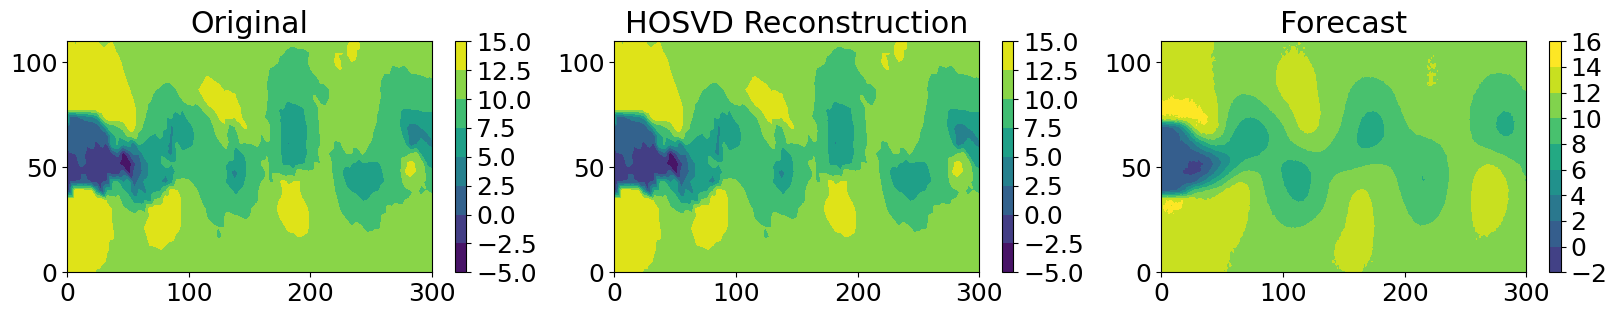

In [ ]:
select_snap = 199
comp = 0

snap_pred = predictions[comp,:,:,select_snap] #+ mean_flow[0,:,:,0]
snap_target_orig = Ten_1[comp,:,:,start_pnt + select_snap]
snap_target = Ten_orig_1[comp,:,:,start_pnt + select_snap]
diff = np.abs(snap_target - snap_pred)

fig3 = plt.figure(figsize=(20,3)) #(20,3)

vmin = np.amin(snap_target_orig)
vmax = np.amax(snap_target_orig)

plt.subplot(1, 3, 1)
plt.contourf(snap_target_orig, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Original")

plt.subplot(1, 3, 2)
plt.contourf(snap_target, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("HOSVD Reconstruction")

plt.subplot(1, 3, 3)
plt.contourf(snap_pred, vmin = vmin, vmax = vmax)
plt.colorbar()
plt.title("Forecast")

# plt.subplot(1, 3, 3)
# plt.contourf(diff, 20, cmap = 'gray')
# plt.colorbar()
# plt.title("Absolute error")

# plt.savefig(f're_ae_cilind_snap_{select_snap}_norm')

In [ ]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim

def calculate_rrmse_flat(predictions, targets):

    rrmse_arr = []
    ssmi_arr = []
    comp = 0

    for i in range(predictions.shape[-1]):
        diff = targets[comp, ..., i] - predictions[comp, ..., i]

        rrmse = np.linalg.norm(diff.flatten(), ord = 2) / np.linalg.norm(targets[comp, ..., i].flatten(), ord = 2)

        rrmse_arr.append(rrmse)

        orig_snap = img_as_float(targets[comp, ..., i])
        pred_snap = img_as_float(predictions[comp, ..., i])

        ssmi_arr.append(ssim(orig_snap, pred_snap, data_range = orig_snap.max() - orig_snap.min()))

    font = {'size'   : 18}

    matplotlib.rc('font', **font)

    len_pred = predictions.shape[-1]

    fig_rrmse = plt.figure(figsize=(25,11))

    plt.subplot(2, 1, 1)
    plt.plot(np.arange(start_pnt, start_pnt + len_pred), rrmse_arr[:len_pred], 'ro-', label='RRMSE', linewidth = 2.0, markersize = 8)
    plt.xticks(np.arange(start_pnt, start_pnt + len_pred + inputWidth, 10.0))

    plt.grid(True, linestyle = "--", linewidth = 1.5)
    plt.title("RRMSE")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(np.arange(start_pnt, start_pnt + len_pred), ssmi_arr[:len_pred], 'ro-', label='ssmi', linewidth = 2.0, markersize = 8)
    plt.xticks(np.arange(start_pnt, start_pnt + len_pred + inputWidth, 10.0))

    plt.grid(True, linestyle = "--", linewidth = 1.5)
    plt.title("SSMI")
    plt.legend()

    return None

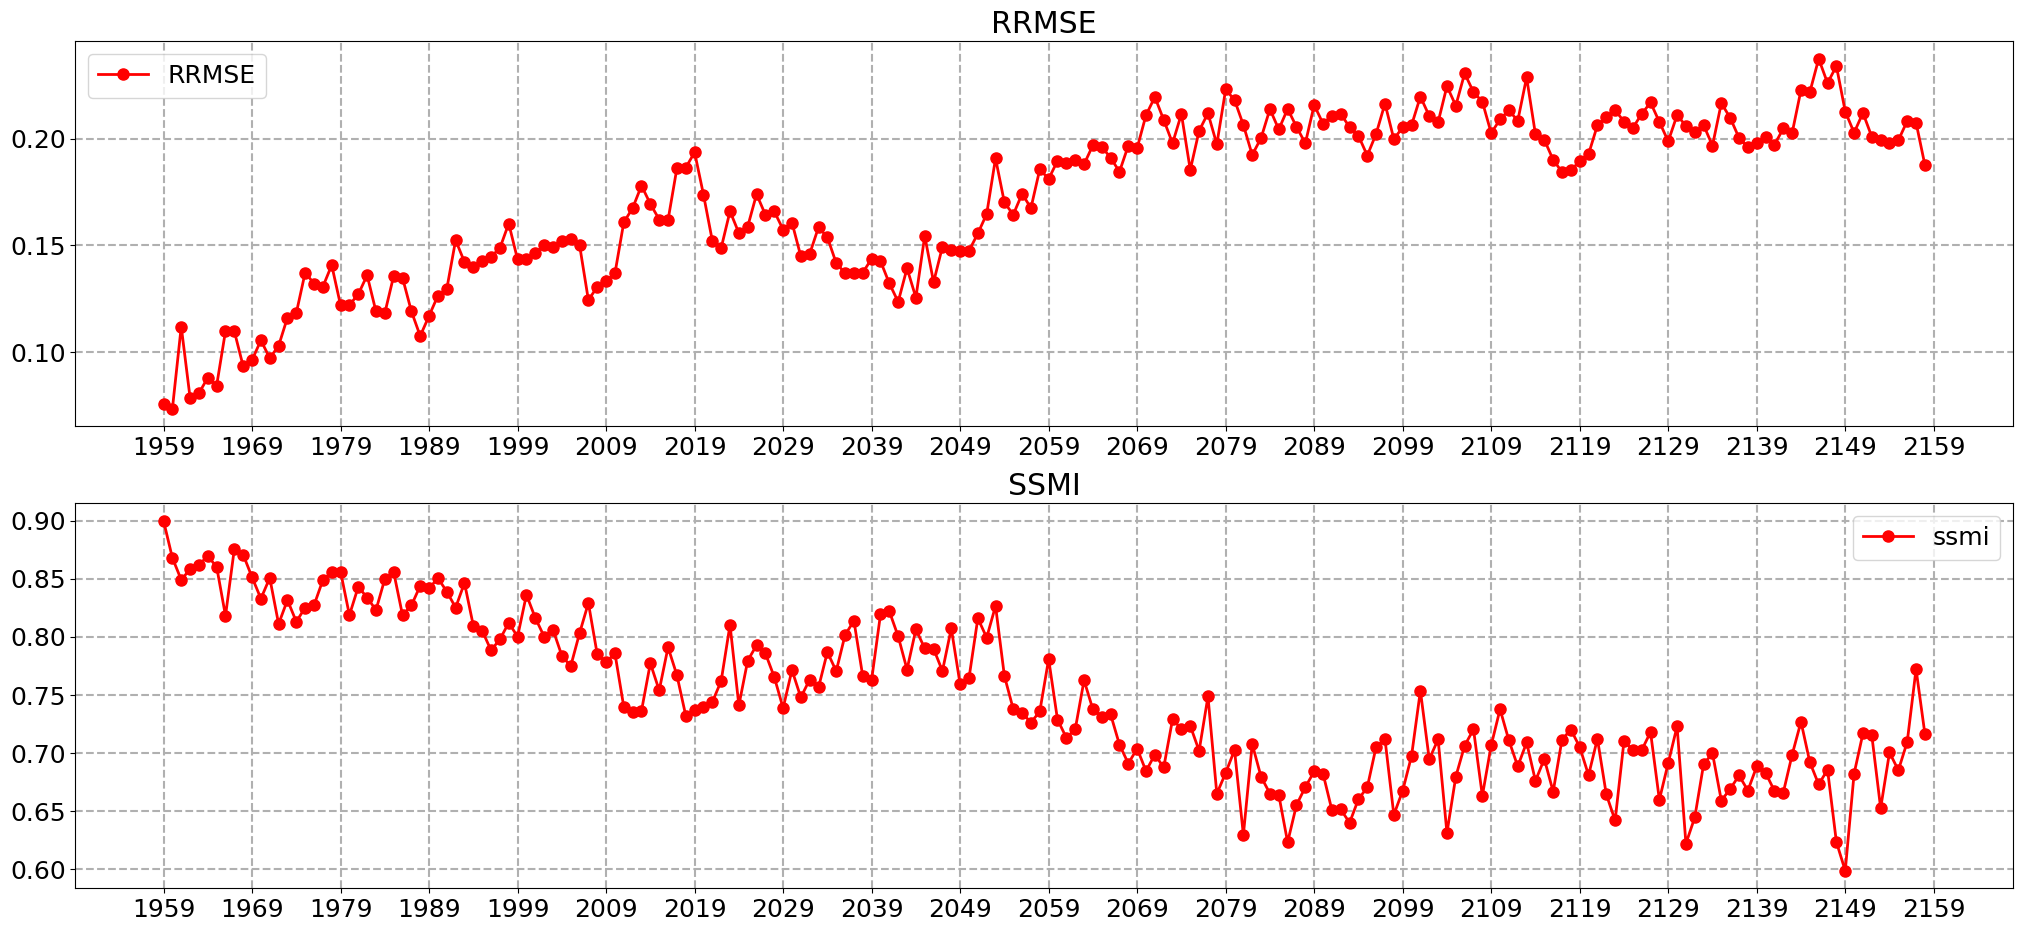

In [ ]:
calculate_rrmse_flat(predictions, Ten_orig_1[:,:,:,start_pnt:])